In [1]:
import pandas as pd 
from pandas import Series
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.api import qqplot  
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import datasets

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
Shanghai = pd.read_csv("/Users/kayinho/Downloads/FiveCitiePMData/ShanghaiPM20100101_20151231.csv")


In [3]:
Shanghai.drop(['PM_Jingan', 'season', 'precipitation', 'Iprec', 'cbwd'], 
               axis=1,
              inplace=True)


In [4]:
Shanghai.dropna(axis=0, how="any", inplace=True)
Shanghai['Time'] = pd.to_datetime(Shanghai['year'].map(str) +"/"+ Shanghai['month'].map(str) +"/"+ Shanghai['day'].map(str)+" "+Shanghai['hour'].map(str)+":00:00")


In [5]:
Shanghai_1 = Shanghai.groupby(['Time']).mean()


In [6]:
Shanghai_1.index = pd.to_datetime(Shanghai_1.index, 
                             format='%d-%m-%Y %H:%M:%S')
Shanghai_1 = Shanghai_1.set_index(Shanghai_1.index).asfreq('H')
Shanghai_1 = Shanghai_1.fillna(method='ffill')
Shanghai_1['Time'] = Shanghai_1.index


In [7]:
Shanghai_13 = Shanghai_1[(Shanghai_1['Time'] >=pd.to_datetime('20130501030000')) & (Shanghai_1['Time'] <= pd.to_datetime('20150430030000'))]
Shanghai_13 = Shanghai_13.set_index(Shanghai_13.index).asfreq('D')



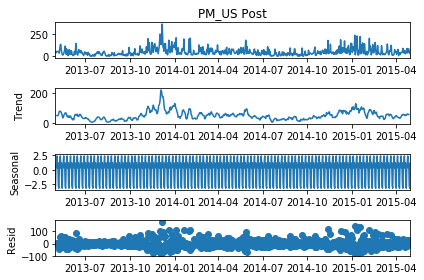

In [8]:
split_result_SH_PM = seasonal_decompose(Shanghai_13['PM_US Post'],  
                            model ='additive') 
split_result_SH_DEWP = seasonal_decompose(Shanghai_13['DEWP'],  
                            model ='additive') 
split_result_SH_HUMI = seasonal_decompose(Shanghai_13['HUMI'],  
                            model ='additive') 
split_result_SH_PRES = seasonal_decompose(Shanghai_13['PRES'],  
                            model ='additive')
split_result_SH_TEMP = seasonal_decompose(Shanghai_13['TEMP'],  
                            model ='additive')
split_result_SH_Iws = seasonal_decompose(Shanghai_13['Iws'],  
                            model ='additive')
split_result_SH_PM.plot();

In [10]:
split_result_SH_PM.resid

Time
2013-05-01 03:00:00         NaN
2013-05-02 03:00:00         NaN
2013-05-03 03:00:00         NaN
2013-05-04 03:00:00   -1.964093
2013-05-05 03:00:00    2.410907
                         ...   
2015-04-26 03:00:00   -7.017665
2015-04-27 03:00:00    1.632061
2015-04-28 03:00:00         NaN
2015-04-29 03:00:00         NaN
2015-04-30 03:00:00         NaN
Freq: D, Name: resid, Length: 730, dtype: float64

In [11]:
# Split data into train / test sets 
dataset = Shanghai_13[['PM_US Post','DEWP','HUMI','PRES', 'TEMP', 'Iws']]
dataset.columns = ['Shanghai_PM2.5','Shanghai_DEWP','Shanghai_HUMI','Shanghai_PRES', 'Shanghai_TEMP', 'Shanghai_Iws']
train = dataset[:len(dataset)-146]
test = dataset[len(dataset)-146:]

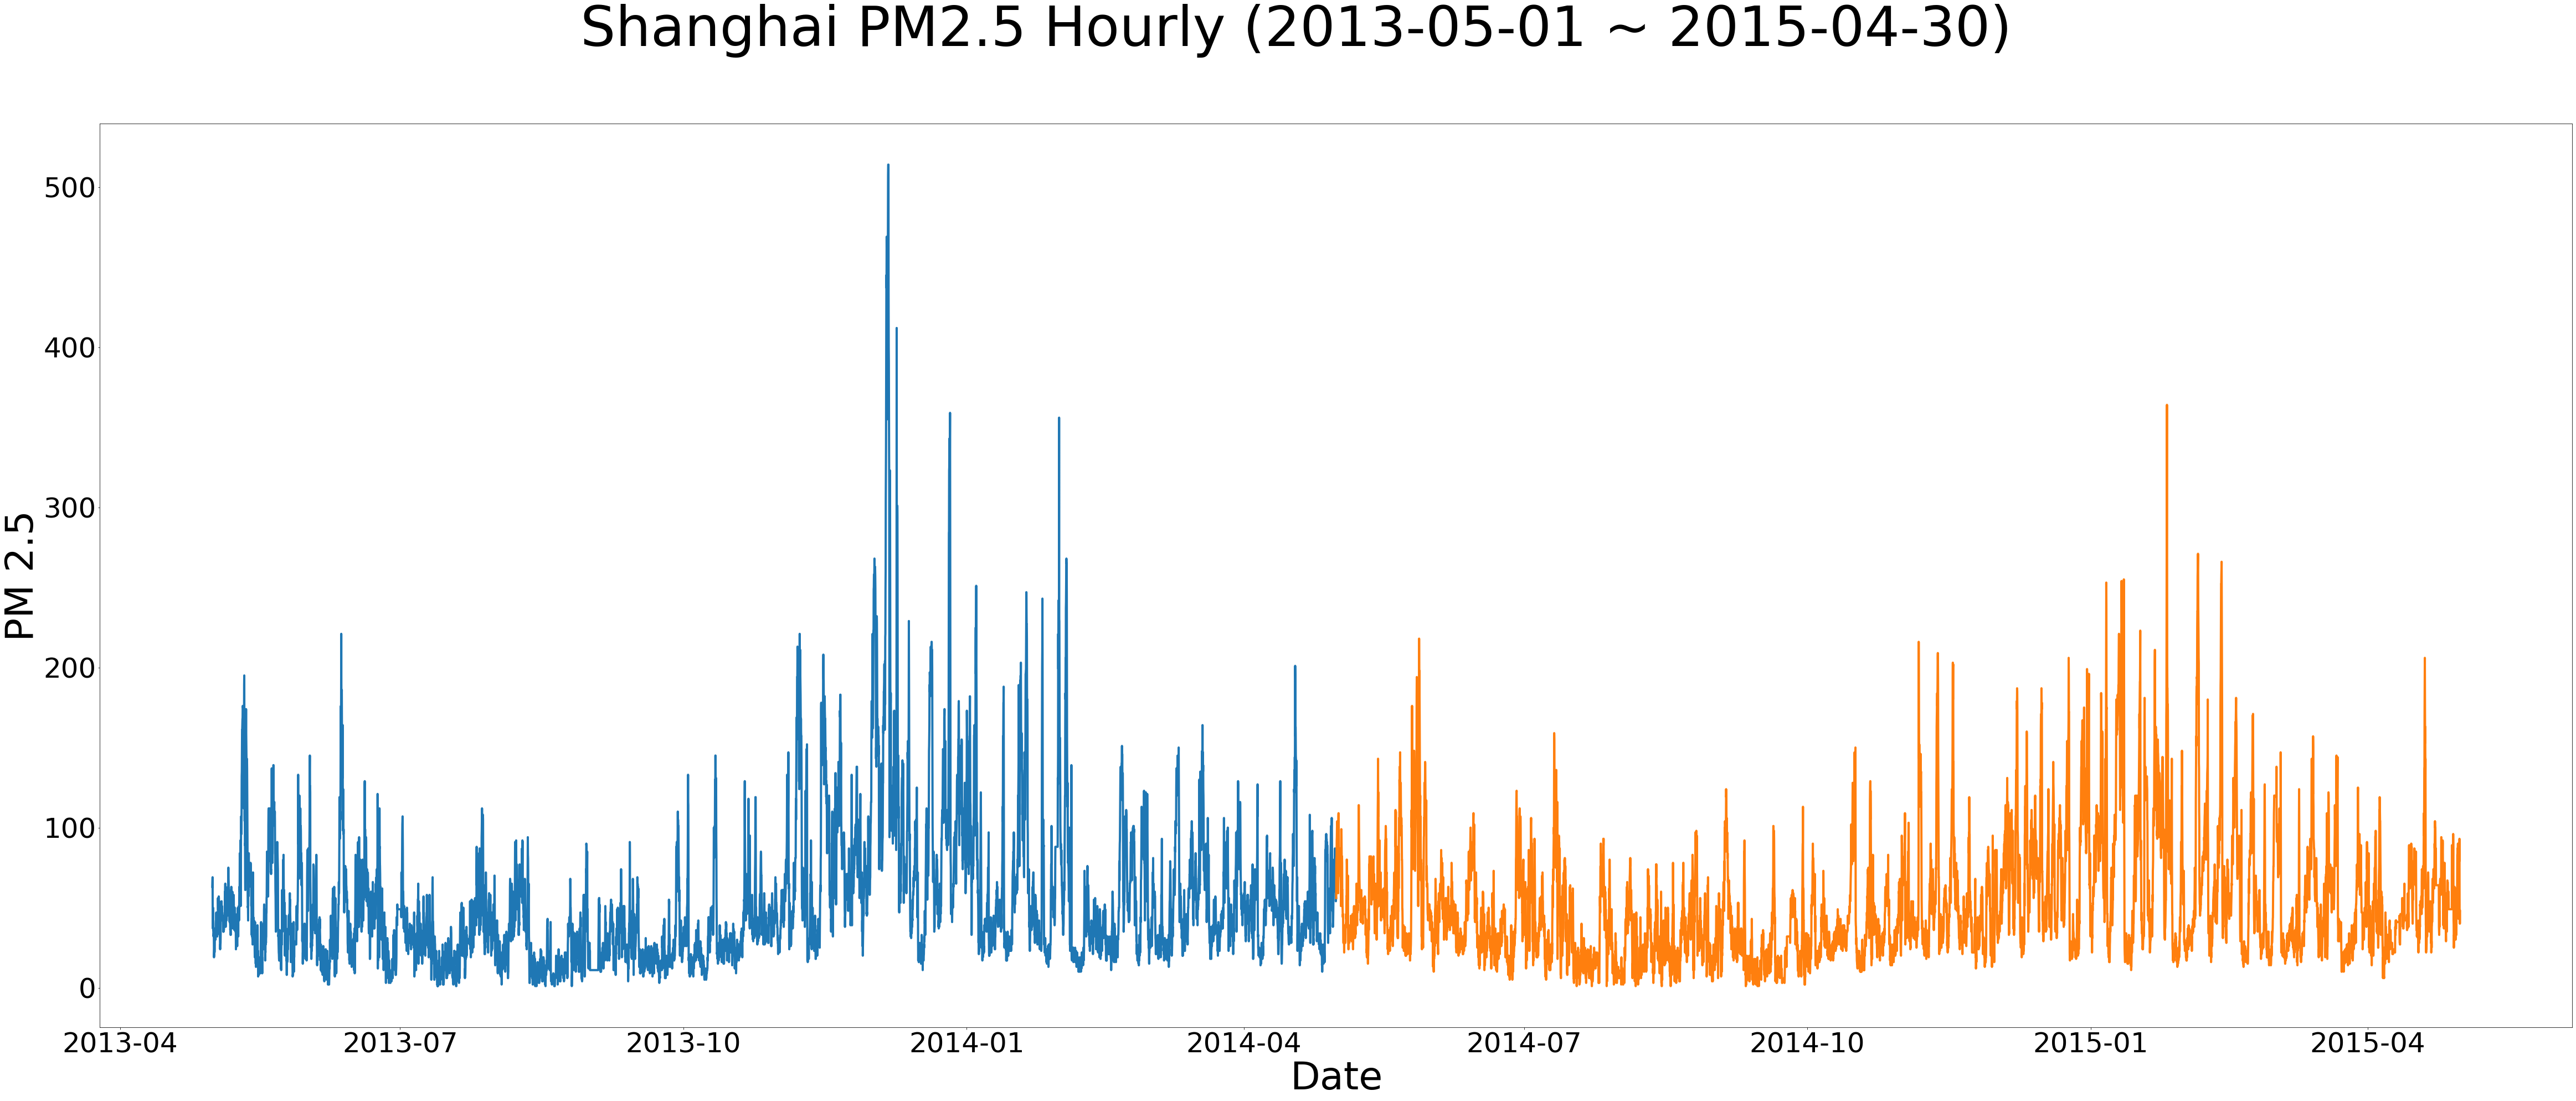

In [12]:
Shanghai_1314 = Shanghai_1[(Shanghai_1['Time'] >=pd.to_datetime('20130501000000')) & (Shanghai_1['Time'] <= pd.to_datetime('20140430230000'))]
Shanghai_1415 = Shanghai_1[(Shanghai_1['Time'] >=pd.to_datetime('20140501000000')) & (Shanghai_1['Time'] <= pd.to_datetime('20150430230000'))]
plt.figure(figsize=(80,30)).suptitle('Shanghai PM2.5 Hourly (2013-05-01 ~ 2015-04-30)', fontsize=100)
plt.plot(Shanghai_1314['Time'], Shanghai_1314['PM_US Post'], linewidth=4)
plt.plot(Shanghai_1415['Time'], Shanghai_1415['PM_US Post'], linewidth=4)


plt.xlabel('Date', fontsize=70)
plt.ylabel('PM 2.5', fontsize=70)
plt.xticks(fontsize=50, rotation=0)
plt.yticks(fontsize=50, rotation=0)
plt.show()


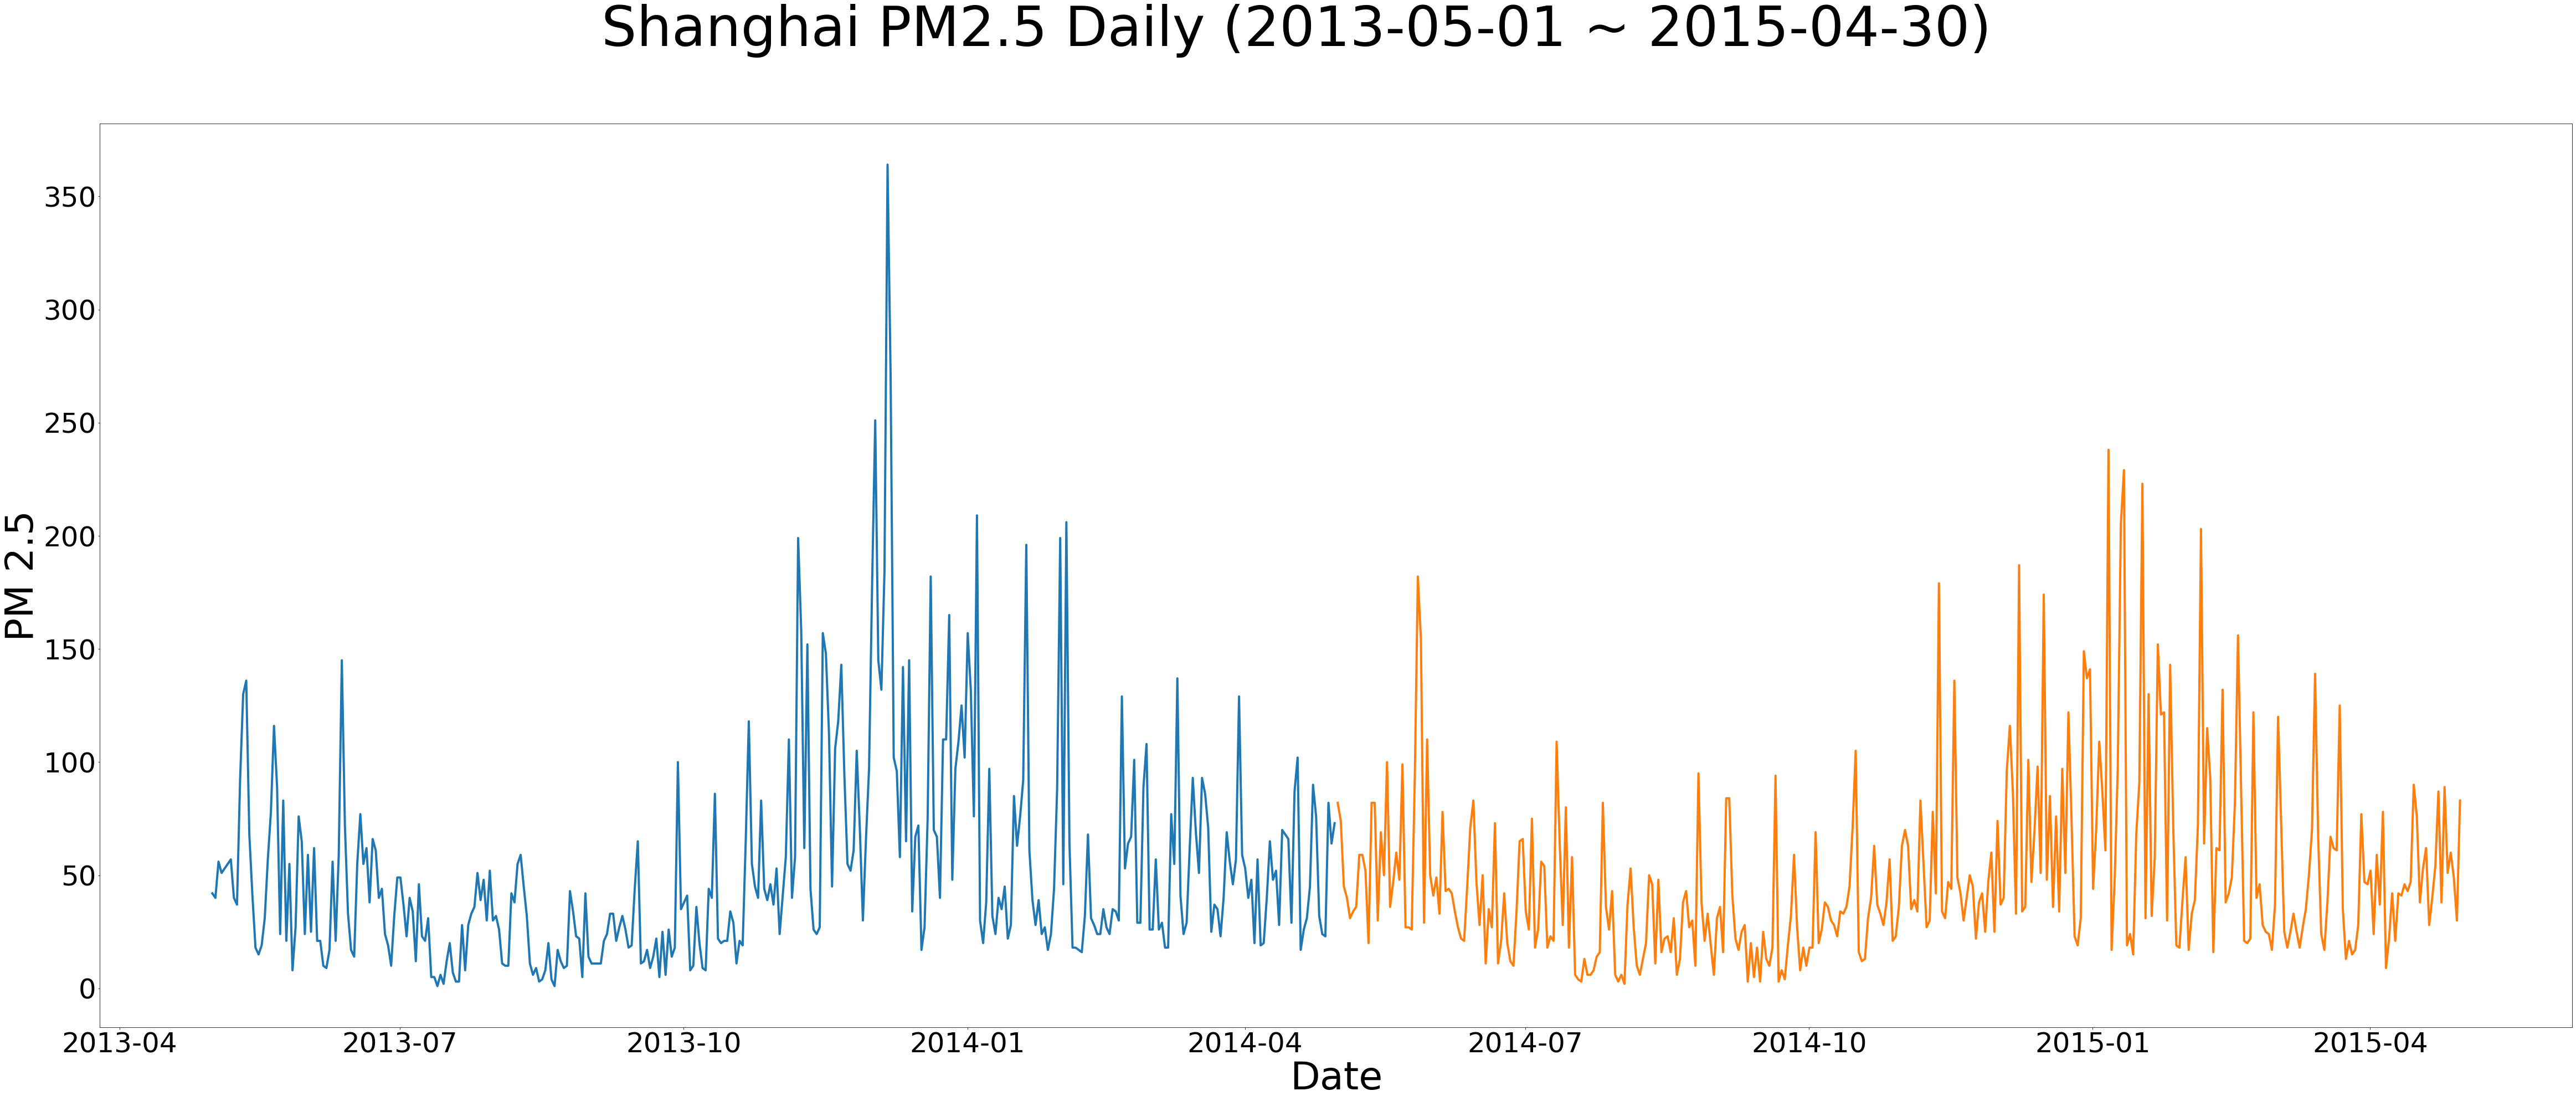

In [13]:
Shanghai_1314 = Shanghai_13[(Shanghai_13['Time'] >=pd.to_datetime('20130501000000')) & (Shanghai_13['Time'] <= pd.to_datetime('20140430230000'))]
Shanghai_1415 = Shanghai_13[(Shanghai_13['Time'] >=pd.to_datetime('20140501000000')) & (Shanghai_13['Time'] <= pd.to_datetime('20150430230000'))]
plt.figure(figsize=(80,30)).suptitle('Shanghai PM2.5 Daily (2013-05-01 ~ 2015-04-30)', fontsize=100)
plt.plot(Shanghai_1314['Time'], Shanghai_1314['PM_US Post'], linewidth=4)
plt.plot(Shanghai_1415['Time'], Shanghai_1415['PM_US Post'], linewidth=4)


plt.xlabel('Date', fontsize=70)
plt.ylabel('PM 2.5', fontsize=70)
plt.xticks(fontsize=50, rotation=0)
plt.yticks(fontsize=50, rotation=0)
plt.show()


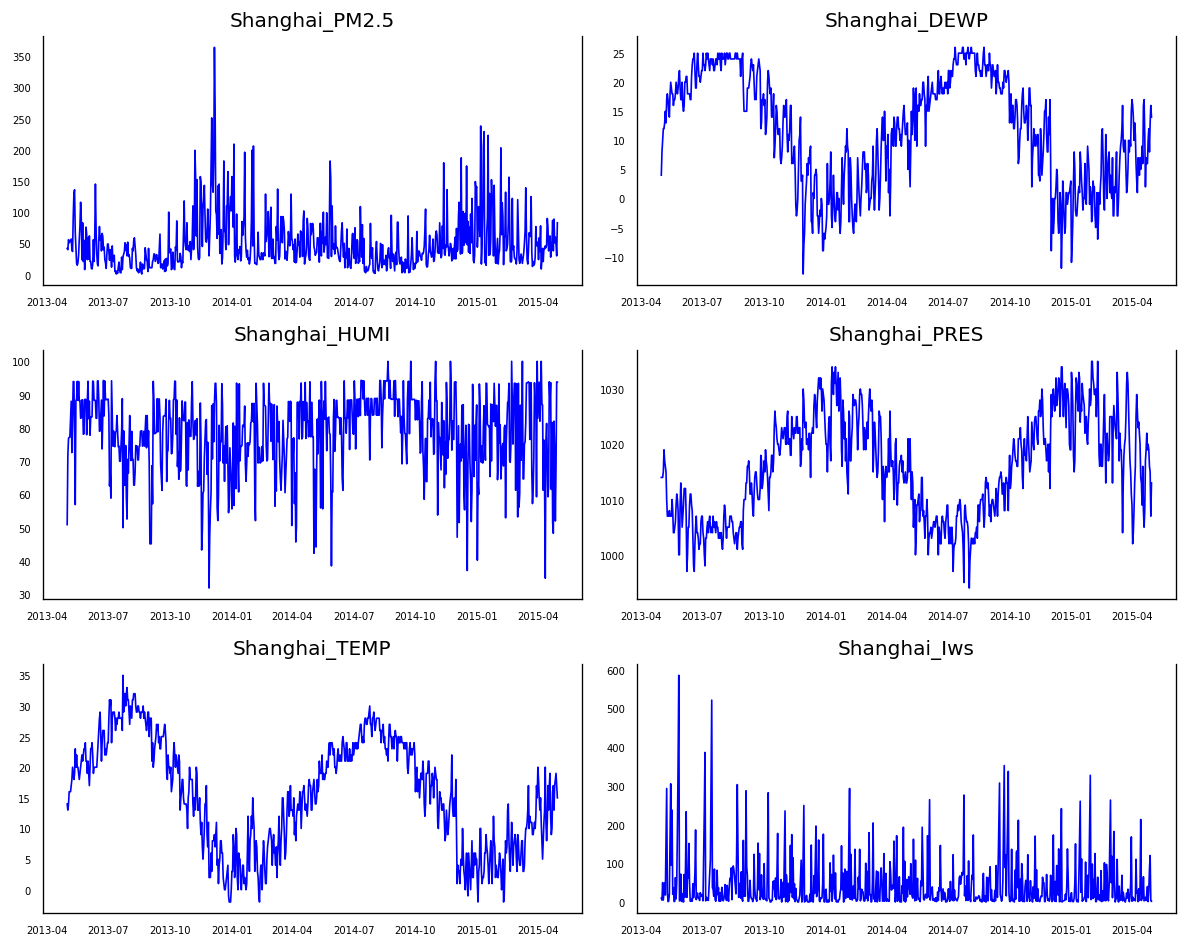

In [14]:
#preliminary plots of each variable
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
    data = dataset[dataset.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(dataset.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

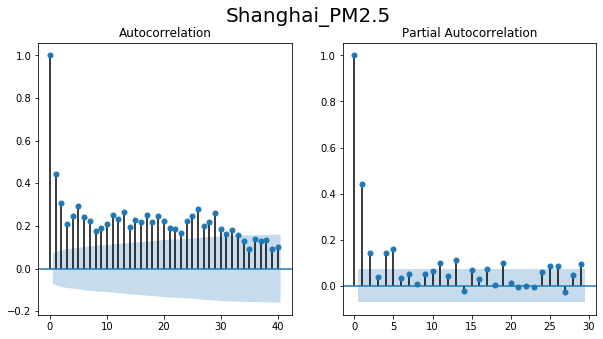

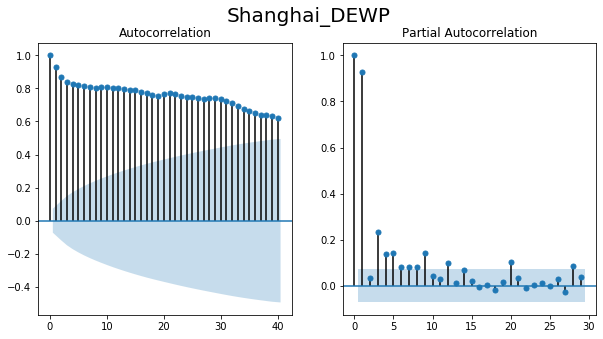

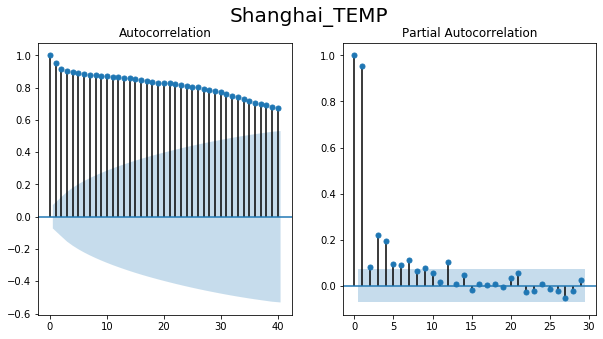

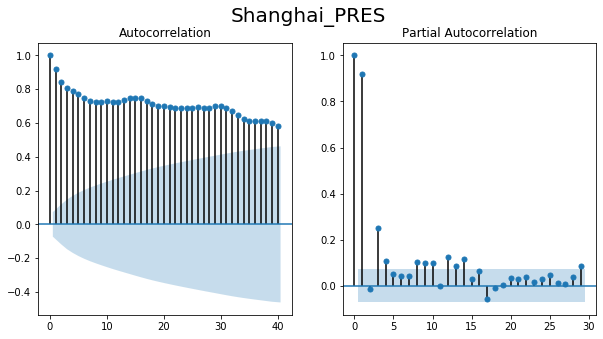

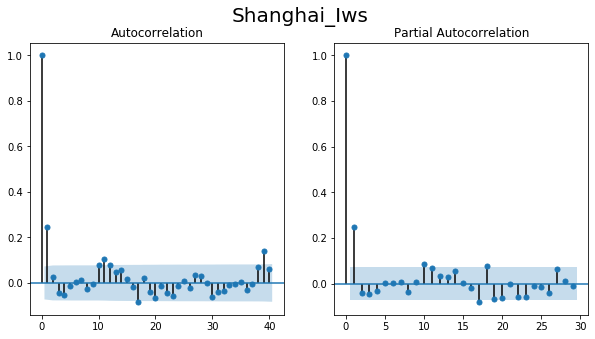

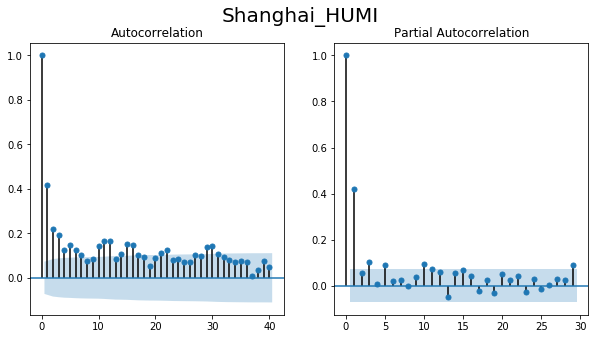

In [15]:
#'Shanghai_PM2.5','Shanghai_DEWP','Shanghai_HUMI','Shanghai_PRES', 'Shanghai_TEMP', 'Shanghai_Iws'
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('Shanghai_PM2.5', fontsize=20)
ax[0] = plot_acf(dataset['Shanghai_PM2.5'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['Shanghai_PM2.5'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('Shanghai_DEWP', fontsize=20)
ax[0] = plot_acf(dataset['Shanghai_DEWP'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['Shanghai_DEWP'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('Shanghai_TEMP', fontsize=20)
ax[0] = plot_acf(dataset['Shanghai_TEMP'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['Shanghai_TEMP'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('Shanghai_PRES', fontsize=20)
ax[0] = plot_acf(dataset['Shanghai_PRES'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['Shanghai_PRES'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('Shanghai_Iws', fontsize=20)
ax[0] = plot_acf(dataset['Shanghai_Iws'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['Shanghai_Iws'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('Shanghai_HUMI', fontsize=20)
ax[0] = plot_acf(dataset['Shanghai_HUMI'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['Shanghai_HUMI'], ax = ax[1])

In [16]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Cointegration Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(train)

Name   ::  Cointegration Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Shanghai_PM2.5 ::  277.5     > 83.9383   =>   True
Shanghai_DEWP ::  182.94    > 60.0627   =>   True
Shanghai_HUMI ::  106.45    > 40.1749   =>   True
Shanghai_PRES ::  43.53     > 24.2761   =>   True
Shanghai_TEMP ::  2.67      > 12.3212   =>   False
Shanghai_Iws ::  0.04      > 4.1296    =>   False


In [17]:
# take aDFuller test the statioinarity of the timeseries
def test_stationarity(timeseries, col):
 #perfprmance Dickey_Fuller Test
    print('Resluts of Dickey-Fuller Test: ' + col)
    dftest=adfuller(timeseries,autolag='AIC')
    output = {'test_statistic':round(dftest[0], 4), 'pvalue':round(dftest[1], 4), 'n_lags':round(dftest[2], 4), 'n_obs':dftest[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)
    dfountput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','Number of obervations used'])
 
    for key,value in dftest[4].items():
        dfountput['Critical Value(%s)'%key]=value
        
    print(dfountput)
    if p_value <= 0.05:
        print(" => Series is Stationary.")
    else:
        print(" => Series is Non-Stationary.") 
# 

In [18]:
for i in train.columns:
    test_stationarity(train[i],i)
    print("\n")


Resluts of Dickey-Fuller Test: Shanghai_PM2.5
Test Statistic                 -3.019492
p-value                         0.033114
#lags used                     14.000000
Number of obervations used    569.000000
Critical Value(1%)             -3.441895
Critical Value(5%)             -2.866633
Critical Value(10%)            -2.569482
dtype: float64
 => Series is Stationary.


Resluts of Dickey-Fuller Test: Shanghai_DEWP
Test Statistic                 -1.118542
p-value                         0.707621
#lags used                     11.000000
Number of obervations used    572.000000
Critical Value(1%)             -3.441834
Critical Value(5%)             -2.866606
Critical Value(10%)            -2.569468
dtype: float64
 => Series is Non-Stationary.


Resluts of Dickey-Fuller Test: Shanghai_HUMI
Test Statistic               -9.374875e+00
p-value                       7.212311e-16
#lags used                    2.000000e+00
Number of obervations used    5.810000e+02
Critical Value(1%)          

In [19]:
train_diff = train.diff().dropna()
train_diff

Shanghai_PM2.5  Shanghai_DEWP  Shanghai_HUMI  \
Time                                                                
2013-05-02 03:00:00            -2.0            4.0          20.74   
2013-05-03 03:00:00            16.0            2.0           5.18   
2013-05-04 03:00:00            -5.0            2.0           0.33   
2013-05-05 03:00:00             2.0            0.0           0.00   
2013-05-06 03:00:00             2.0            1.0           5.23   
...                             ...            ...            ...   
2014-12-01 03:00:00            49.0          -10.0         -12.28   
2014-12-02 03:00:00           -37.0          -16.0         -34.47   
2014-12-03 03:00:00             3.0            7.0          17.76   
2014-12-04 03:00:00            56.0            2.0          15.73   
2014-12-05 03:00:00            20.0           -6.0         -29.07   

                     Shanghai_PRES  Shanghai_TEMP  Shanghai_Iws  
Time                                                             
2013-05-02 03:00:00            0.0           -1.0          -5.0  
2013-05-03 03:00:00            0.0            1.0          45.0  
2013-05-04 03:00:00            1.0            2.0         -45.0  
2013-05-05 03:00:00            4.0            0.0          24.0  
2013-05-06 03:00:00           -2.0            0.0          21.0  
...                            ...            ...           ...  
2014-12-01 03:00:00           11.0           -8.0          61.0  
2014-12-02 03:00:00            6.0           -9.0         -24.0  
2014-12-03 03:00:00           -4.0            3.0         -44.0  
2014-12-04 03:00:00            3.0           -1.0          47.0  
2014-12-05 03:00:00            2.0            0.0         125.0  

[583 rows x 6 columns]

In [20]:
for i in train_diff.columns:
    test_stationarity(train_diff[i],i)
    print("\n")

Resluts of Dickey-Fuller Test: Shanghai_PM2.5
Test Statistic               -9.564868e+00
p-value                       2.371923e-16
#lags used                    1.700000e+01
Number of obervations used    5.650000e+02
Critical Value(1%)           -3.441977e+00
Critical Value(5%)           -2.866669e+00
Critical Value(10%)          -2.569502e+00
dtype: float64
 => Series is Stationary.


Resluts of Dickey-Fuller Test: Shanghai_DEWP
Test Statistic               -1.062066e+01
p-value                       5.526562e-19
#lags used                    1.000000e+01
Number of obervations used    5.720000e+02
Critical Value(1%)           -3.441834e+00
Critical Value(5%)           -2.866606e+00
Critical Value(10%)          -2.569468e+00
dtype: float64
 => Series is Stationary.


Resluts of Dickey-Fuller Test: Shanghai_HUMI
Test Statistic               -8.542895e+00
p-value                       9.675236e-14
#lags used                    1.900000e+01
Number of obervations used    5.630000e+02
Crit

In [21]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=30
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(train_diff, variables = dataset.columns) 

Shanghai_PM2.5_x  Shanghai_DEWP_x  Shanghai_HUMI_x  \
Shanghai_PM2.5_y            1.0000           0.0365           0.1085   
Shanghai_DEWP_y             0.0025           1.0000           0.0001   
Shanghai_HUMI_y             0.0435           0.0000           1.0000   
Shanghai_PRES_y             0.0006           0.0080           0.0844   
Shanghai_TEMP_y             0.0033           0.0023           0.0026   
Shanghai_Iws_y              0.1132           0.2667           0.1962   

                  Shanghai_PRES_x  Shanghai_TEMP_x  Shanghai_Iws_x  
Shanghai_PM2.5_y           0.0000           0.0717          0.0082  
Shanghai_DEWP_y            0.0000           0.0003          0.0049  
Shanghai_HUMI_y            0.0000           0.0000          0.0957  
Shanghai_PRES_y            1.0000           0.0047          0.0000  
Shanghai_TEMP_y            0.0062           1.0000          0.0728  
Shanghai_Iws_y             0.0282           0.0084          1.0000

In [23]:
from statsmodels.tsa.api import VAR
model = VAR(train_diff)
    
x = model.select_order(maxlags=50)
x.summary()
#min AIC/FPE: lag 6

<class 'statsmodels.iolib.table.SimpleTable'>

In [24]:
results = model.fit(maxlags=50, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, May, 2020
Time:                     17:24:47
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    23.0311
Nobs:                     577.000    HQIC:                   22.0082
Log likelihood:          -10851.1    FPE:                1.88175e+09
AIC:                      21.3544    Det(Omega_mle):     1.29601e+09
--------------------------------------------------------------------
Results for equation Shanghai_PM2.5
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.078013         1.443864            0.054           0.957
L1.Shanghai_PM2.5        -0.583228         0.043993          -13.257           0.000
L1.Shanghai_DEWP         -3.557790 

In [26]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic: [0,4]; 
#close to 2 = no significant serial correlation
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)
print("Durbin-Watson Test: ")
def adjust(val, length= 6): return str(val).ljust(length)
for col, val in zip(train.columns, out):
    print(adjust(col), ':', round(val, 2))

Durbin-Watson Test: 
Shanghai_PM2.5 : 1.99
Shanghai_DEWP : 1.99
Shanghai_HUMI : 2.0
Shanghai_PRES : 2.03
Shanghai_TEMP : 2.0
Shanghai_Iws : 2.01


In [27]:
# Get the lag order
lag_order = results.k_ar
#print(lag_order)

# Input data for forecasting
forecast_input = train_diff.values[-lag_order:]

#results.forecast(dataset.values[-lag_order:], 15)
fc = results.forecast(y=forecast_input, steps=15)
result_forecast = pd.DataFrame(fc, index=dataset.index[-15:], columns=dataset.columns + '_forecast')
#print(result_forecast)

In [28]:
fcInterval = results.forecast_interval(forecast_input, steps = 15, alpha=0.05, exog_future=None)
result_forecast = pd.DataFrame(fcInterval[0], index = dataset.index[-15:], columns = dataset.columns + '_1d')
result_forecast_lower  = pd.DataFrame(fcInterval[1], index = dataset.index[-15:], columns = dataset.columns + "_forecast_1d_lower")
result_forecast_upper = pd.DataFrame(fcInterval[2], index = dataset.index[-15:], columns = dataset.columns + "_forecast_1d_upper")

In [29]:
def invert_transformation(train, result_forecast, word):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = result_forecast.copy()
    columns = train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)+ word].cumsum()
    return df_fc
df_results = invert_transformation(train, result_forecast, '_1d')
df_results_forecast = df_results[['Shanghai_PM2.5_forecast', 'Shanghai_DEWP_forecast', 'Shanghai_HUMI_forecast', 
                                'Shanghai_PRES_forecast', 'Shanghai_TEMP_forecast', 'Shanghai_Iws_forecast']]
for col in df_results_forecast.columns:
    df_results_forecast[col+'_lower'] = df_results_forecast[col] + result_forecast_lower[col+'_1d_lower']
    df_results_forecast[col+'_upper'] = df_results_forecast[col] + result_forecast_upper[col+'_1d_upper']    
df_results_forecast

Shanghai_PM2.5_forecast  Shanghai_DEWP_forecast  \
Time                                                                   
2015-04-16 03:00:00                78.445961               -0.678290   
2015-04-17 03:00:00                66.912974                0.734784   
2015-04-18 03:00:00                91.325821               -0.220511   
2015-04-19 03:00:00                93.600603               -0.772024   
2015-04-20 03:00:00                75.310178               -0.687184   
2015-04-21 03:00:00                75.388459               -0.108938   
2015-04-22 03:00:00                85.272812               -1.177426   
2015-04-23 03:00:00                81.864607               -1.247794   
2015-04-24 03:00:00                85.541671               -1.317961   
2015-04-25 03:00:00                83.656819               -1.327624   
2015-04-26 03:00:00                83.185104               -1.065966   
2015-04-27 03:00:00                82.505201               -0.889610   
2015-04-28 03:00:00                81.203100               -0.782701   
2015-04-29 03:00:00                82.709378               -0.903036   
2015-04-30 03:00:00                83.292154               -1.091062   

                     Shanghai_HUMI_forecast  Shanghai_PRES_forecast  \
Time                                                                  
2015-04-16 03:00:00               67.581561             1027.563505   
2015-04-17 03:00:00               67.443475             1027.114830   
2015-04-18 03:00:00               67.526666             1027.165628   
2015-04-19 03:00:00               67.942947             1026.695316   
2015-04-20 03:00:00               66.808456             1026.498016   
2015-04-21 03:00:00               67.891551             1025.684274   
2015-04-22 03:00:00               65.457082             1026.832985   
2015-04-23 03:00:00               65.787290             1027.134961   
2015-04-24 03:00:00               65.949512             1027.312234   
2015-04-25 03:00:00               65.735792             1027.310274   
2015-04-26 03:00:00               66.586891             1027.214377   
2015-04-27 03:00:00               66.531491             1027.011835   
2015-04-28 03:00:00               66.675385             1026.897467   
2015-04-29 03:00:00               66.441962             1026.942715   
2015-04-30 03:00:00               66.342692             1027.012244   

                     Shanghai_TEMP_forecast  Shanghai_Iws_forecast  \
Time                                                                 
2015-04-16 03:00:00                5.106785              51.207797   
2015-04-17 03:00:00                6.388424              75.788760   
2015-04-18 03:00:00                5.423745              34.500645   
2015-04-19 03:00:00                4.822937              47.826923   
2015-04-20 03:00:00                5.175767              85.237137   
2015-04-21 03:00:00                5.529726              70.029623   
2015-04-22 03:00:00                5.048635              80.431143   
2015-04-23 03:00:00                4.828846              72.903111   
2015-04-24 03:00:00                4.662968              63.929714   
2015-04-25 03:00:00                4.717572              58.099385   
2015-04-26 03:00:00                4.822879              64.442045   
2015-04-27 03:00:00                5.008429              69.859494   
2015-04-28 03:00:00                5.101109              72.709286   
2015-04-29 03:00:00                5.037139              71.670253   
2015-04-30 03:00:00                4.850924              68.750292   

                     Shanghai_PM2.5_forecast_lower  \
Time                                                 
2015-04-16 03:00:00                     -27.057298   
2015-04-17 03:00:00                     -23.767804   
2015-04-18 03:00:00                      35.900092   
2015-04-19 03:00:00                      15.421653   
2015-04-20 03:00:00                     -24.048114   
2015-04-21 03:00:00

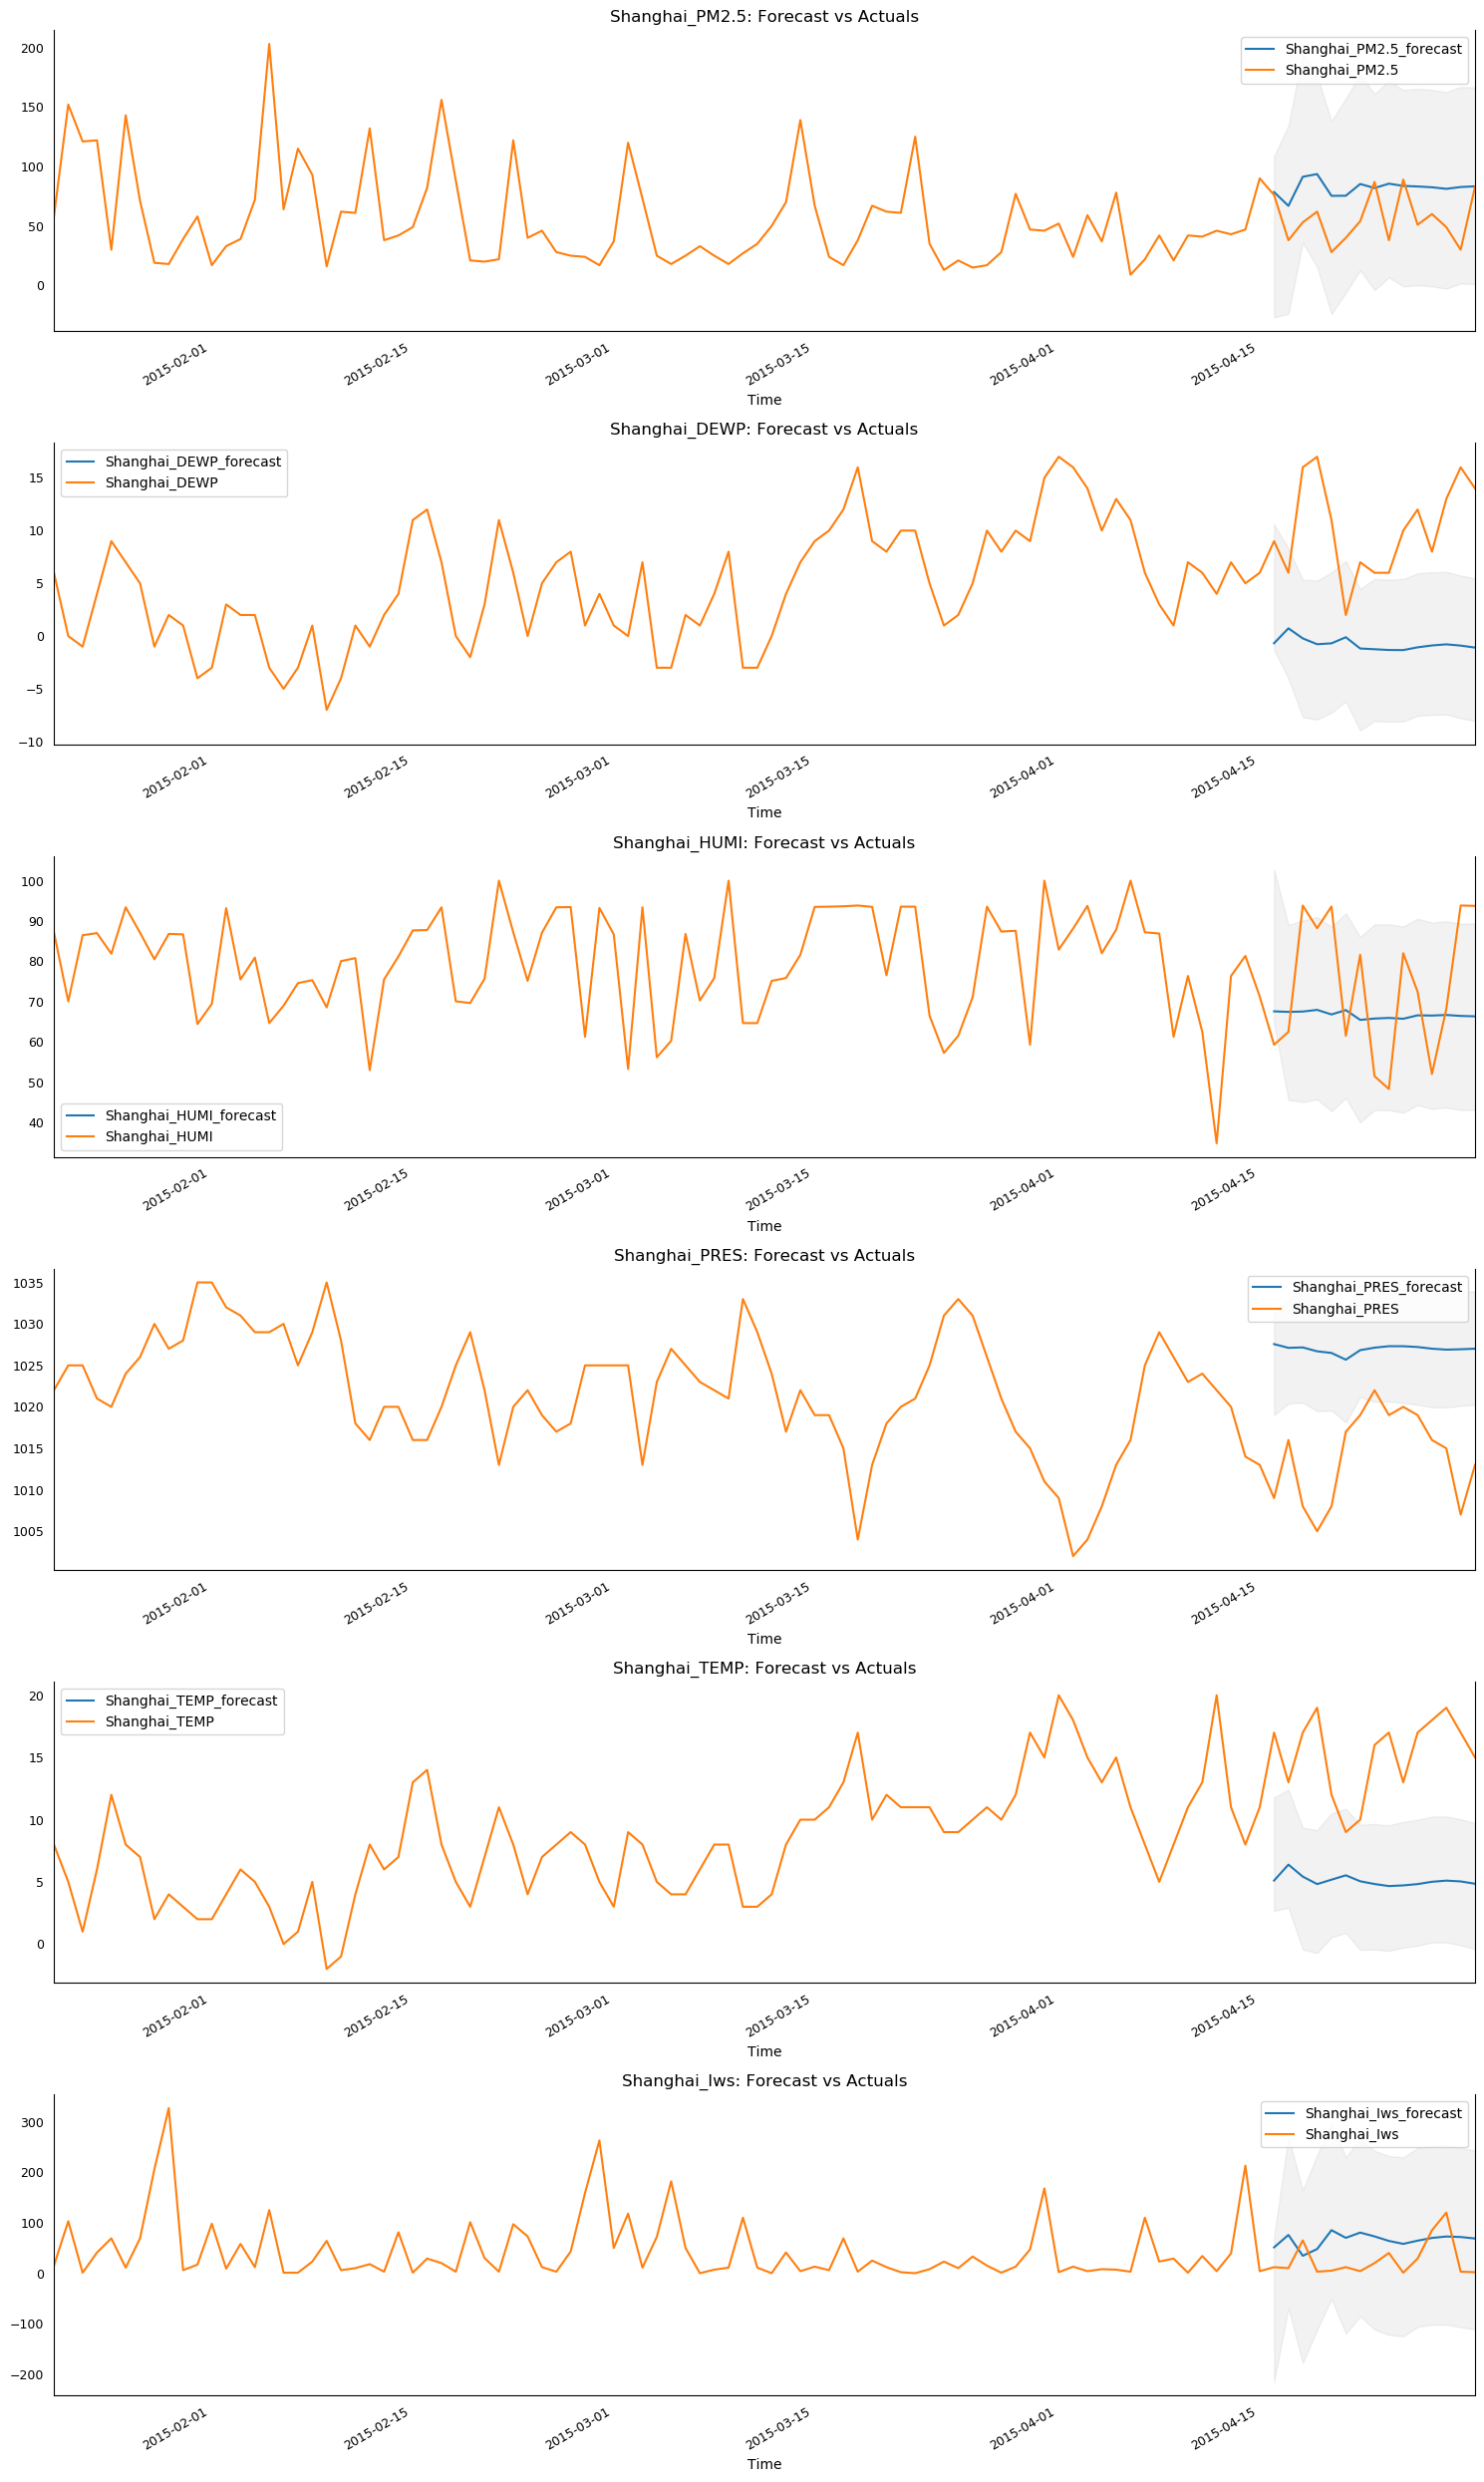

In [30]:
#results.plot_forecast(150, plot_stderr= False);
fig, axes = plt.subplots(nrows=int(len(dataset.columns)), ncols=1, dpi=100, figsize=(15,25))
for i, (col,ax) in enumerate(zip(dataset.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dataset[col][-100:].plot(legend=True, ax=ax);
    ax.fill_between(df_results.index, df_results_forecast[col+'_forecast_lower'], df_results_forecast[col+'_forecast_upper'], color='k', alpha=0.05)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=9)

plt.tight_layout();

In [32]:
test = dataset[len(dataset)-146:]

In [33]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test[['Shanghai_PM2.5', 'Shanghai_DEWP','Shanghai_HUMI','Shanghai_PRES', 'Shanghai_TEMP', 'Shanghai_Iws']][-15:], 
                                  df_results[['Shanghai_PM2.5_forecast','Shanghai_DEWP_forecast','Shanghai_HUMI_forecast','Shanghai_PRES_forecast', 'Shanghai_TEMP_forecast', 'Shanghai_Iws_forecast']][-15:]))
print("Overall RMSE: ", rmse)

Overall RMSE:  28.053959603411244


In [34]:
rmse_PM = np.sqrt(mean_squared_error(test[['Shanghai_PM2.5']][-15:], 
                                  df_results[['Shanghai_PM2.5_forecast']][-15:]))
print("RMSE for Shanghai_PM2.5_forecast: ", rmse_PM)

rmse_DEWP = np.sqrt(mean_squared_error(test[['Shanghai_DEWP']][-15:], 
                                  df_results[['Shanghai_DEWP_forecast']][-15:]))
print("RMSE for Shanghai_DEWP_forecast: ", rmse_DEWP)

rmse_HUMI = np.sqrt(mean_squared_error(test[['Shanghai_HUMI']][-15:], 
                                  df_results[['Shanghai_HUMI_forecast']][-15:]))
print("RMSE for Shanghai_HUMI_forecast: ", rmse_HUMI)

rmse_PRES = np.sqrt(mean_squared_error(test[['Shanghai_PRES']][-15:], 
                                  df_results[['Shanghai_PRES_forecast']][-15:]))
print("RMSE for Shanghai_PRES_forecast: ", rmse_PRES)

rmse_TEMP = np.sqrt(mean_squared_error(test[['Shanghai_TEMP']][-15:], 
                                  df_results[['Shanghai_TEMP_forecast']][-15:]))
print("RMSE for Shanghai_TEMP_forecast: ", rmse_TEMP)

rmse_Iws = np.sqrt(mean_squared_error(test[['Shanghai_Iws']][-15:], 
                                  df_results[['Shanghai_Iws_forecast']][-15:]))
print("RMSE for Shanghai_Iws_forecast ", rmse_Iws)

RMSE for Shanghai_PM2.5_forecast:  32.09454286204986
RMSE for Shanghai_DEWP_forecast:  11.820344551391116
RMSE for Shanghai_HUMI_forecast:  17.78576270852464
RMSE for Shanghai_PRES_forecast:  13.804207726321682
RMSE for Shanghai_TEMP_forecast:  10.662210887973336
RMSE for Shanghai_Iws_forecast  54.14605639052967


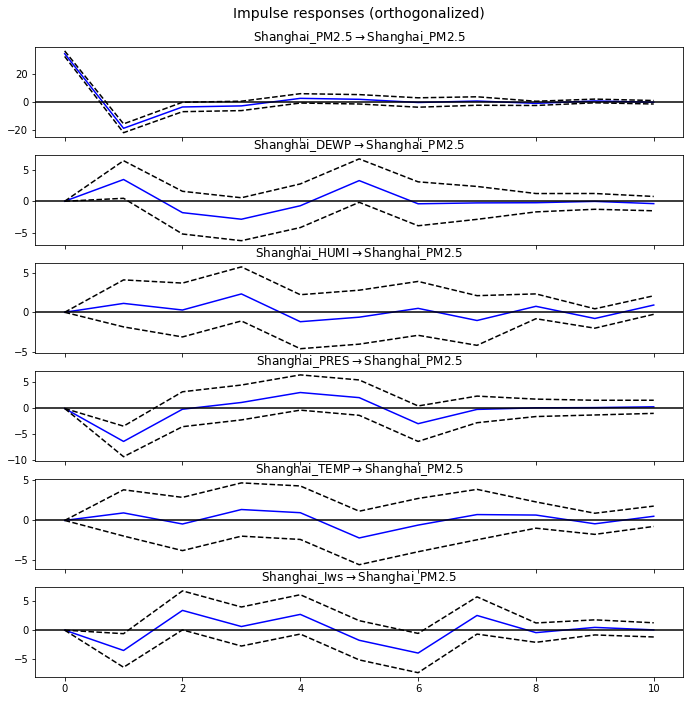

In [36]:
#impulse response analysis
irf = results.irf(10)
irf.plot(orth=True, response = "Shanghai_PM2.5");

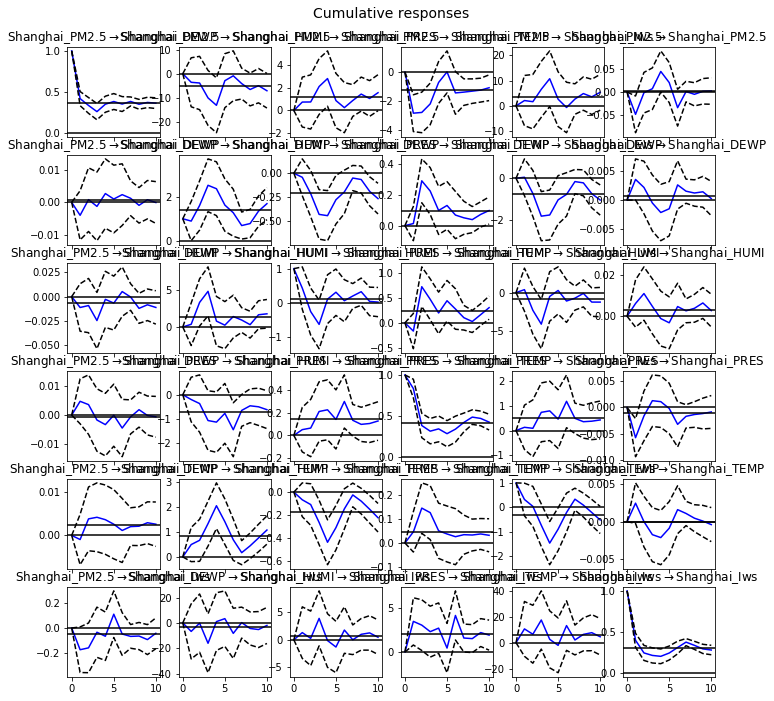

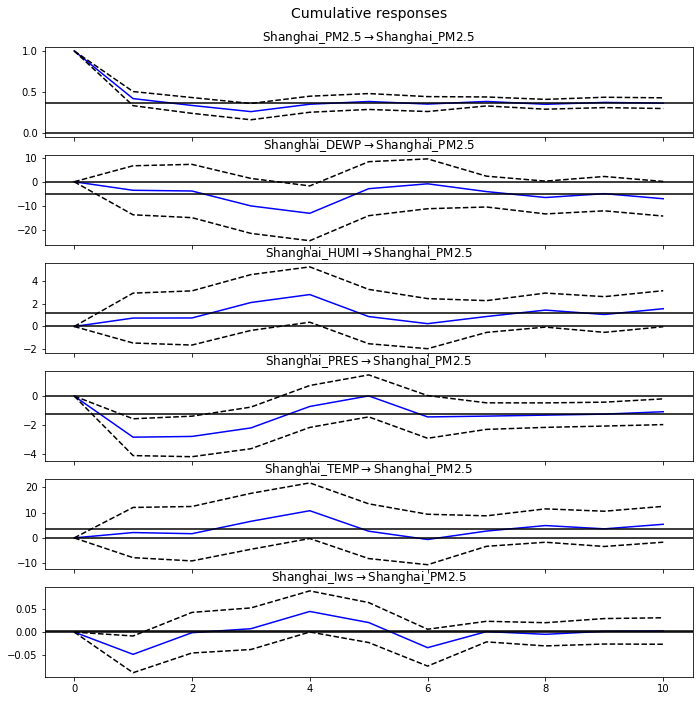

In [37]:
#impulse response analysis wiht cumulative effect
irf.plot_cum_effects(orth=False);
irf_cum = irf.plot_cum_effects(orth=False, response = "Shanghai_PM2.5")


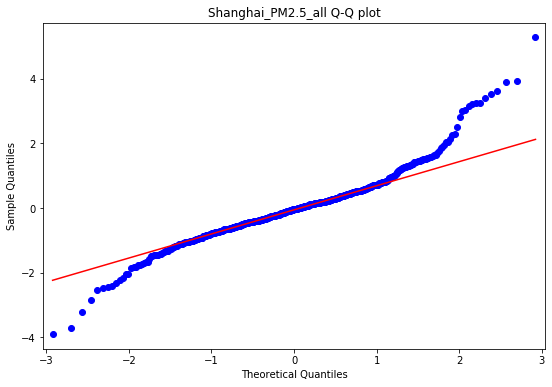

In [38]:
resid = results.resid['Shanghai_PM2.5']
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid, line='q', ax=ax, fit=True)
plt.title("Shanghai_PM2.5_all Q-Q plot")
plt.show()

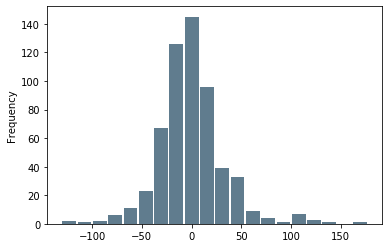

In [40]:
resid.plot.hist(grid=False, bins=20, rwidth=0.9,
                   color='#607c8e')

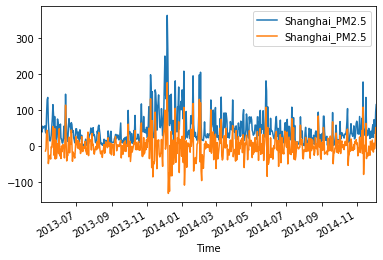

In [41]:
train['Shanghai_PM2.5'].plot(legend=True)
resid.plot(legend=True)

In [42]:
#Forecast Error Variance Decomposition (FEVD) method
fevd = results.fevd(5)
fevd.summary()

FEVD for Shanghai_PM2.5
     Shanghai_PM2.5  Shanghai_DEWP  Shanghai_HUMI  Shanghai_PRES  Shanghai_TEMP  Shanghai_Iws
0          1.000000       0.000000       0.000000       0.000000       0.000000      0.000000
1          0.959304       0.007293       0.000778       0.024691       0.000542      0.007392
2          0.950984       0.009144       0.000814       0.024278       0.000653      0.014127
3          0.941562       0.013839       0.004014       0.024698       0.001747      0.014140
4          0.931015       0.013929       0.004789       0.029838       0.002268      0.018161

FEVD for Shanghai_DEWP
     Shanghai_PM2.5  Shanghai_DEWP  Shanghai_HUMI  Shanghai_PRES  Shanghai_TEMP  Shanghai_Iws
0          0.021060       0.978940       0.000000       0.000000       0.000000      0.000000
1          0.028479       0.948014       0.017012       0.000007       0.000010      0.006478
2          0.025916       0.905430       0.016693       0.041139       0.004167      0.006655
3          0

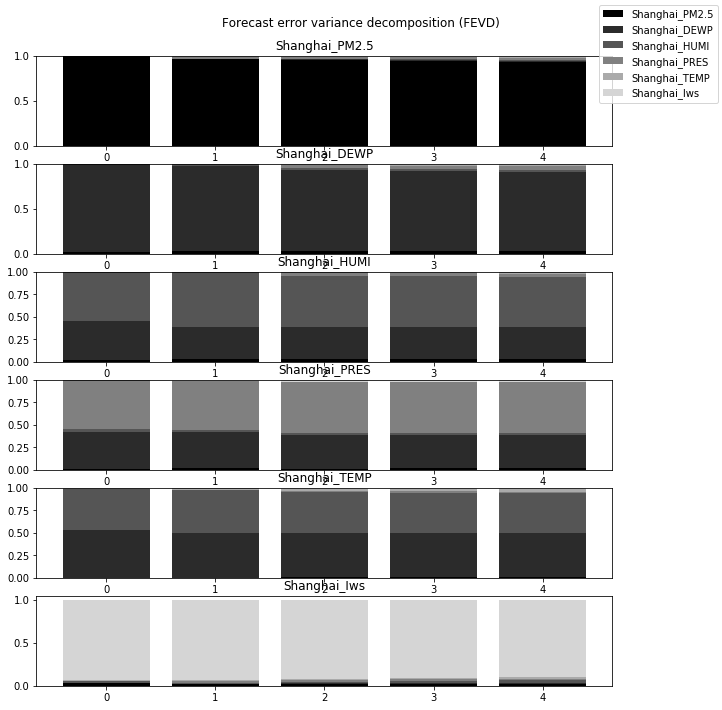

In [43]:
fevd.plot();

In [48]:
# ADF Test on each column
for i in train2.columns:
    test_stationarity(train2[i],i)
    print('\n')
    

Resluts of Dickey-Fuller Test: Shanghai_PM2.5_w/PRES
Test Statistic                 -3.019492
p-value                         0.033114
#lags used                     14.000000
Number of obervations used    569.000000
Critical Value(1%)             -3.441895
Critical Value(5%)             -2.866633
Critical Value(10%)            -2.569482
dtype: float64
 => Series is Stationary.


Resluts of Dickey-Fuller Test: Shanghai_PRES
Test Statistic                 -1.214146
p-value                         0.667481
#lags used                     15.000000
Number of obervations used    568.000000
Critical Value(1%)             -3.441915
Critical Value(5%)             -2.866642
Critical Value(10%)            -2.569487
dtype: float64
 => Series is Non-Stationary.




In [50]:
from statsmodels.tsa.api import VAR

dataset22 = Shanghai_13[['PM_US Post','DEWP','PRES', 'Iws']]
dataset22.columns = ['Shanghai_PM2.5_w/oHUMI_TEMP','Shanghai_DEWP','Shanghai_PRES', 'Shanghai_Iws']
train22 = dataset22[:len(dataset22)-146]
test22 = dataset22[len(dataset22)-146:]

train22_diff = train22.diff().dropna()
#train22_diff

model22 = VAR(train22_diff)
    
#x22 = model22.select_order(maxlags=220)
#x22.summary()

results22 = model22.fit(maxlags=50, ic='aic')
print(results22.summary())

lag_order22 = results22.k_ar
#print(lag_order)

# Input data for forecasting
forecast_input22 = train22_diff.values[-lag_order22:]

#results.forecast(dataset.values[-lag_order:], 220)
fc22 = results22.forecast(y=forecast_input22, steps=15)
result_forecast22 = pd.DataFrame(fc22, index=dataset22.index[-15:], columns=dataset22.columns + '_forecast')
#print(result_forecast)

df_results22 = invert_transformation(train22, result_forecast22, '_forecast')  

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, May, 2020
Time:                     17:30:43
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    20.5744
Nobs:                     577.000    HQIC:                   20.1136
Log likelihood:          -8892.72    FPE:                4.04971e+08
AIC:                      19.8191    Det(Omega_mle):     3.41776e+08
--------------------------------------------------------------------
Results for equation Shanghai_PM2.5_w/oHUMI_TEMP
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                  0.145788         1.452110            0.100           0.920
L1.Shanghai_PM2.5_w/oHUMI_TEMP        -0.562691         0.043452    

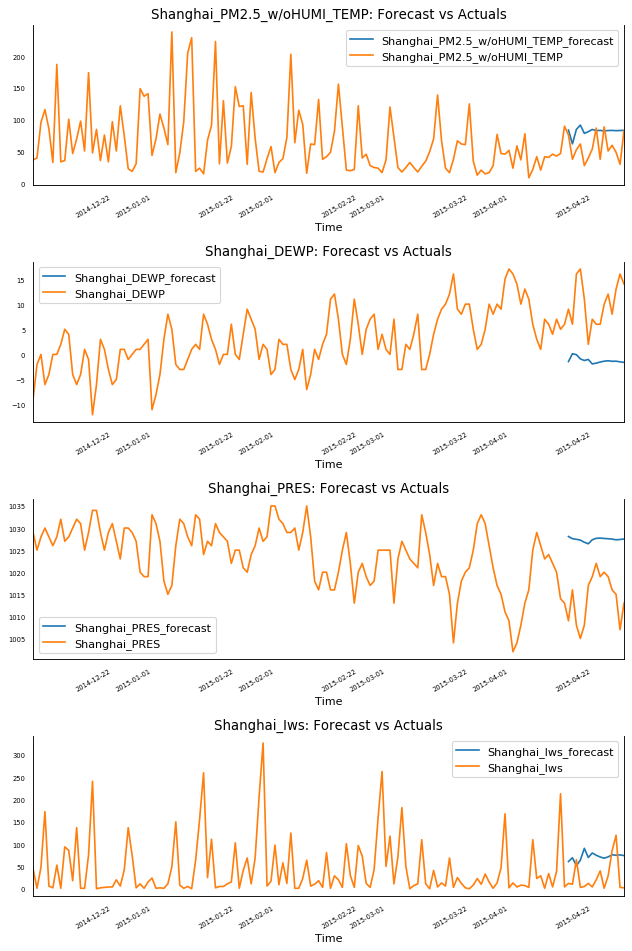

In [51]:
#results2.plot_forecast(150, plot_stderr= False);
fig, axes = plt.subplots(nrows=int(len(dataset22.columns)), ncols=1, dpi=80, figsize=(8,12))
for i, (col,ax) in enumerate(zip(dataset22.columns, axes.flatten())):
    df_results22[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dataset22[col][-150:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [52]:
dataset33 = Shanghai_13[['PM_US Post','DEWP','HUMI','PRES', 'Iws']]
dataset33.columns = ['Shanghai_PM2.5_w/oTEMP','Shanghai_DEWP', 'Shanghai_HUMI','Shanghai_PRES', 'Shanghai_Iws']
train33 = dataset33[:len(dataset33)-146]
test33 = dataset33[len(dataset33)-146:]

train33_diff = train33.diff().dropna()
#train33_diff

model33 = VAR(train33_diff)
    
#x33 = model33.select_order(maxlags=330)
#x33.summary()

results33 = model33.fit(maxlags=30, ic='aic')
print(results33.summary())

lag_order33 = results33.k_ar
#print(lag_order)

# Input data for forecasting
forecast_input33 = train33_diff.values[-lag_order33:]

#results.forecast(dataset.values[-lag_order:], 330)
fc33 = results33.forecast(y=forecast_input33, steps=15)
result_forecast33 = pd.DataFrame(fc33, index=dataset33.index[-15:], columns=dataset33.columns + '_forecast')
#print(result_forecast)

df_results33 = invert_transformation(train33, result_forecast33, '_forecast')  

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, May, 2020
Time:                     17:30:57
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    24.7472
Nobs:                     578.000    HQIC:                   24.1490
Log likelihood:          -10839.3    FPE:                2.09831e+10
AIC:                      23.7667    Det(Omega_mle):     1.68393e+10
--------------------------------------------------------------------
Results for equation Shanghai_PM2.5_w/oTEMP
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.107463         1.446645            0.074           0.941
L1.Shanghai_PM2.5_w/oTEMP        -0.574168         0.043516          -13.194           0

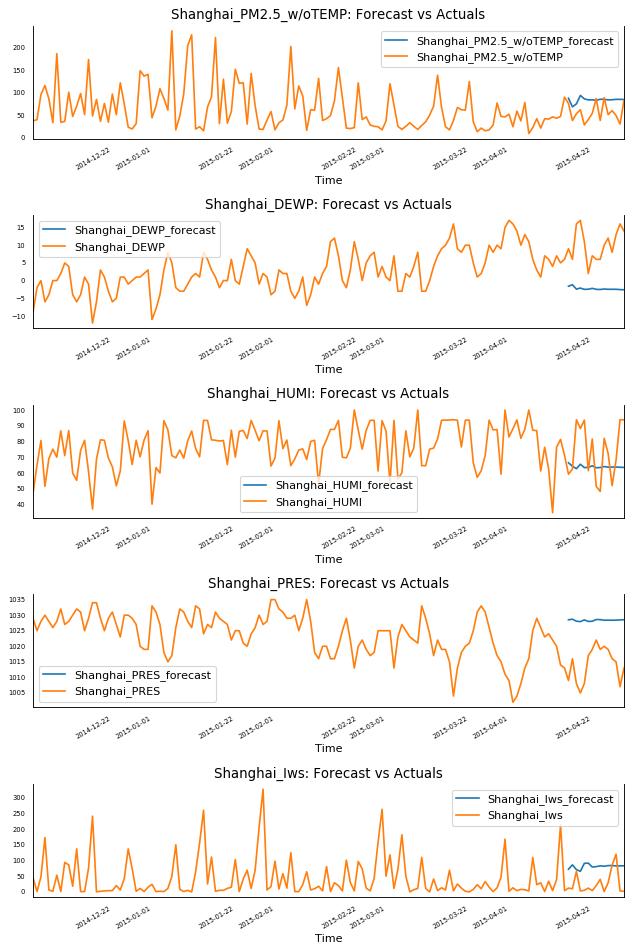

In [53]:
#results2.plot_forecast(150, plot_stderr= False);
fig, axes = plt.subplots(nrows=int(len(dataset33.columns)), ncols=1, dpi=80, figsize=(8,12))
for i, (col,ax) in enumerate(zip(dataset33.columns, axes.flatten())):
    df_results33[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dataset33[col][-150:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [54]:
dataset44 = Shanghai_13[['PM_US Post','DEWP','PRES','TEMP', 'Iws']]
dataset44.columns = ['Shanghai_PM2.5_w/oHUMI','Shanghai_DEWP','Shanghai_PRES', 'Shanghai_TEMP', 'Shanghai_Iws']
train44 = dataset44[:len(dataset44)-146]
test44 = dataset44[len(dataset44)-146:]

train44_diff = train44.diff().dropna()
#train44_diff

model44 = VAR(train44_diff)
    
#x44 = model44.select_order(maxlags=440)
#x44.summary()

results44 = model44.fit(maxlags=30, ic='aic')
print(results44.summary())

lag_order44 = results44.k_ar
#print(lag_order)

# Input data for forecasting
forecast_input44 = train44_diff.values[-lag_order44:]

#results.forecast(dataset.values[-lag_order:], 440)
fc44 = results44.forecast(y=forecast_input44, steps=15)
result_forecast44 = pd.DataFrame(fc44, index=dataset44.index[-15:], columns=dataset44.columns + '_forecast')
#print(result_forecast)

df_results44 = invert_transformation(train44, result_forecast44, '_forecast')  

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, May, 2020
Time:                     17:31:01
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    21.7368
Nobs:                     578.000    HQIC:                   21.1386
Log likelihood:          -9969.28    FPE:                1.03383e+09
AIC:                      20.7562    Det(Omega_mle):     8.29664e+08
--------------------------------------------------------------------
Results for equation Shanghai_PM2.5_w/oHUMI
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.114449         1.449136            0.079           0.937
L1.Shanghai_PM2.5_w/oHUMI        -0.571352         0.043511          -13.131           0

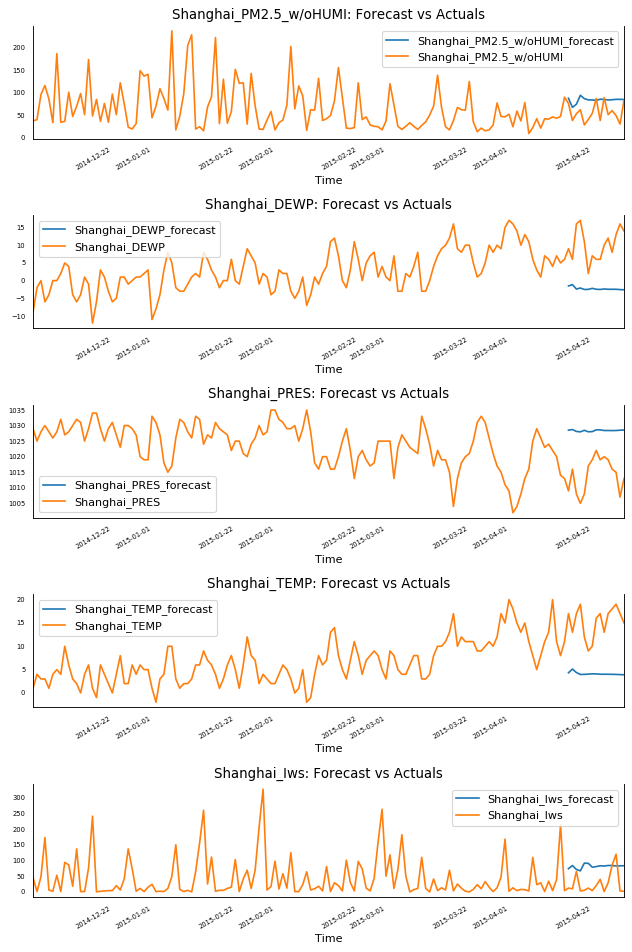

In [55]:
#results2.plot_forecast(150, plot_stderr= False);
fig, axes = plt.subplots(nrows=int(len(dataset44.columns)), ncols=1, dpi=80, figsize=(8,12))
for i, (col,ax) in enumerate(zip(dataset44.columns, axes.flatten())):
    df_results44[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dataset44[col][-150:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [56]:
from sklearn.metrics import mean_squared_error
rmse22 = np.sqrt(mean_squared_error(test22[['Shanghai_PM2.5_w/oHUMI_TEMP','Shanghai_DEWP','Shanghai_PRES', 'Shanghai_Iws']][-15:], 
                                  df_results22[['Shanghai_PM2.5_w/oHUMI_TEMP_forecast','Shanghai_DEWP_forecast','Shanghai_PRES_forecast','Shanghai_Iws_forecast']][-15:]))
print("Overall RMSE: ", rmse22)

Overall RMSE:  34.175059913551365


In [57]:
rmse_PM22 = np.sqrt(mean_squared_error(test22[['Shanghai_PM2.5_w/oHUMI_TEMP']][-15:], 
                                  df_results22[['Shanghai_PM2.5_w/oHUMI_TEMP_forecast']][-15:]))
print("RMSE for Shanghai_PM2.5_forecast: ", rmse_PM22)



RMSE for Shanghai_PM2.5_forecast:  32.09330082470033


In [58]:
rmse_PM33 = np.sqrt(mean_squared_error(test33[['Shanghai_PM2.5_w/oTEMP']][-15:], 
                                  df_results33[['Shanghai_PM2.5_w/oTEMP_forecast']][-15:]))
print("RMSE for Shanghai_PM2.5_forecast: ", rmse_PM33)

RMSE for Shanghai_PM2.5_forecast:  33.7213529259457


In [59]:
rmse_PM44 = np.sqrt(mean_squared_error(test44[['Shanghai_PM2.5_w/oHUMI']][-15:], 
                                  df_results44[['Shanghai_PM2.5_w/oHUMI_forecast']][-15:]))
print("RMSE for Shanghai_PM2.5_forecast: ", rmse_PM44)

RMSE for Shanghai_PM2.5_forecast:  33.68230930454846


In [60]:
# Split data into train / test sets 
dataset2 = Shanghai_13[['PM_US Post','PRES']]
dataset2.columns = ['Shanghai_PM2.5_w/PRES','Shanghai_PRES']
train2 = dataset2[:len(dataset2)-146]
test2 = dataset2[len(dataset2)-146:]

In [61]:
train2_diff = train2.diff().dropna()
train2_diff

Shanghai_PM2.5_w/PRES  Shanghai_PRES
Time                                                     
2013-05-02 03:00:00                   -2.0            0.0
2013-05-03 03:00:00                   16.0            0.0
2013-05-04 03:00:00                   -5.0            1.0
2013-05-05 03:00:00                    2.0            4.0
2013-05-06 03:00:00                    2.0           -2.0
...                                    ...            ...
2014-12-01 03:00:00                   49.0           11.0
2014-12-02 03:00:00                  -37.0            6.0
2014-12-03 03:00:00                    3.0           -4.0
2014-12-04 03:00:00                   56.0            3.0
2014-12-05 03:00:00                   20.0            2.0

[583 rows x 2 columns]

In [62]:
model2 = VAR(train2_diff)
    
x2 = model2.select_order(maxlags=30)
#x2.summary()

In [63]:
results2 = model2.fit(maxlags=30, ic='aic')
print(results2.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, May, 2020
Time:                     17:31:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.90420
Nobs:                     568.000    HQIC:                   9.61519
Log likelihood:          -4228.10    FPE:                    12462.2
AIC:                      9.43024    Det(Omega_mle):         11205.7
--------------------------------------------------------------------
Results for equation Shanghai_PM2.5_w/PRES
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.180280         1.420736            0.127           0.899
L1.Shanghai_PM2.5_w/PRES         -0.633337         0.043159          -14.675           0.

In [64]:
lag_order2 = results2.k_ar
#print(lag_order)

# Input data for forecasting
forecast_input2 = train2_diff.values[-lag_order2:]

#results.forecast(dataset.values[-lag_order:], 30)
fc2 = results2.forecast(y=forecast_input2, steps=15)
result_forecast2 = pd.DataFrame(fc2, index=dataset2.index[-15:], columns=dataset2.columns + '_1d')
#print(result_forecast)

In [65]:
df_results2 = invert_transformation(train2, result_forecast2, '_1d')  

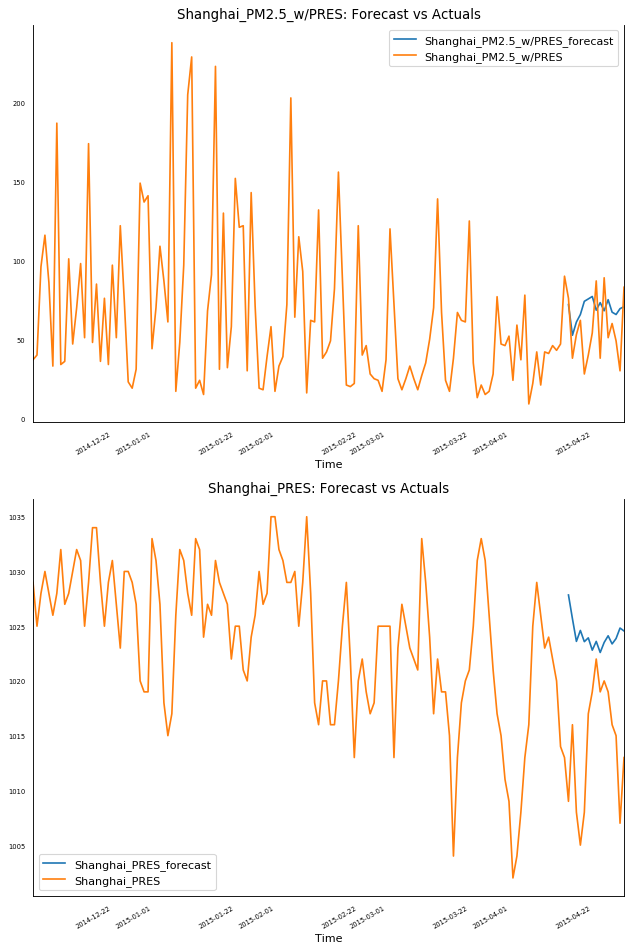

In [66]:
#results2.plot_forecast(150, plot_stderr= False);
fig, axes = plt.subplots(nrows=int(len(dataset2.columns)), ncols=1, dpi=80, figsize=(8,12))
for i, (col,ax) in enumerate(zip(dataset2.columns, axes.flatten())):
    df_results2[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dataset2[col][-150:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [67]:
test2 = dataset2[len(dataset2)-146:]

In [68]:
rmse2 = np.sqrt(mean_squared_error(test2[['Shanghai_PM2.5_w/PRES','Shanghai_PRES']][-15:], 
                                  df_results2[['Shanghai_PM2.5_w/PRES_forecast','Shanghai_PRES_forecast']][-15:]))
print("Overall RMSE: ", rmse2)

Overall RMSE:  19.054742418785377


In [69]:
rmse_PM2 = np.sqrt(mean_squared_error(test2[['Shanghai_PM2.5_w/PRES']][-15:], 
                                  df_results2[['Shanghai_PM2.5_w/PRES_forecast']][-15:]))
print("RMSE for Shanghai_PM2.5_forecast: ", rmse_PM2)

rmse_PRES2 = np.sqrt(mean_squared_error(test2[['Shanghai_PRES']][-15:], 
                                  df_results2[['Shanghai_PRES_forecast']][-15:]))
print("RMSE for Shanghai_PRES_forecast: ", rmse_PRES2)

#rmse_Iws2 = np.sqrt(mean_squared_error(test2[['Shanghai_Iws']][-15:], 
#                                 df_results2[['Shanghai_Iws_forecast']][-15:]))
#print("RMSE for Shanghai_Iws_forecast ", rmse_Iws2)

RMSE for Shanghai_PM2.5_forecast:  24.317894279006445
RMSE for Shanghai_PRES_forecast:  11.610617344809155


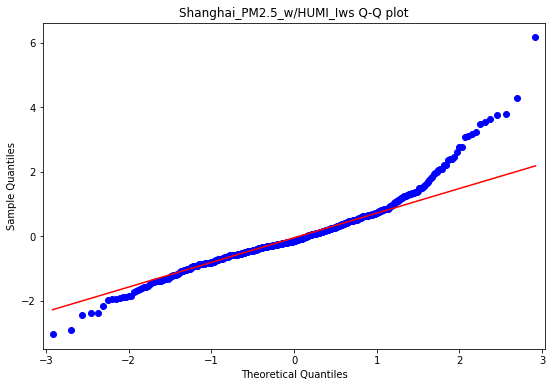

In [70]:
resid2 = results2.resid['Shanghai_PM2.5_w/PRES']
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid2, line='q', ax=ax, fit=True)
plt.title("Shanghai_PM2.5_w/HUMI_Iws Q-Q plot")
plt.show()

In [80]:
# Split data into train / test sets 
dataset3 = Shanghai_13[['PM_US Post','DEWP']]
dataset3.columns = ['Shanghai_PM2.5_w/DEWP','Shanghai_DEWP']
train3 = dataset3[:len(dataset)-146]
test3 = dataset3[len(dataset)-146:]


In [82]:
# ADF Test on each column
for i in train3.columns:
    test_stationarity(train3[i],i)
    print('\n')

Resluts of Dickey-Fuller Test: Shanghai_PM2.5_w/DEWP
Test Statistic                 -3.019492
p-value                         0.033114
#lags used                     14.000000
Number of obervations used    569.000000
Critical Value(1%)             -3.441895
Critical Value(5%)             -2.866633
Critical Value(10%)            -2.569482
dtype: float64
 => Series is Stationary.


Resluts of Dickey-Fuller Test: Shanghai_DEWP
Test Statistic                 -1.118542
p-value                         0.707621
#lags used                     11.000000
Number of obervations used    572.000000
Critical Value(1%)             -3.441834
Critical Value(5%)             -2.866606
Critical Value(10%)            -2.569468
dtype: float64
 => Series is Non-Stationary.




In [83]:
train3_diff = train3.diff().dropna()
train3_diff

Shanghai_PM2.5_w/DEWP  Shanghai_DEWP
Time                                                     
2013-05-02 03:00:00                   -2.0            4.0
2013-05-03 03:00:00                   16.0            2.0
2013-05-04 03:00:00                   -5.0            2.0
2013-05-05 03:00:00                    2.0            0.0
2013-05-06 03:00:00                    2.0            1.0
...                                    ...            ...
2014-12-01 03:00:00                   49.0          -10.0
2014-12-02 03:00:00                  -37.0          -16.0
2014-12-03 03:00:00                    3.0            7.0
2014-12-04 03:00:00                   56.0            2.0
2014-12-05 03:00:00                   20.0           -6.0

[583 rows x 2 columns]

In [84]:
model3 = VAR(train3_diff)
    
x3 = model3.select_order(maxlags=30)
#x3.summary()


In [85]:
results3 = model3.fit(maxlags=30, ic='aic')
results3.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, May, 2020
Time:                     17:33:04
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.83219
Nobs:                     571.000    HQIC:                   9.60003
Log likelihood:          -4268.83    FPE:                    12728.8
AIC:                      9.45151    Det(Omega_mle):         11683.4
--------------------------------------------------------------------
Results for equation Shanghai_PM2.5_w/DEWP
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -0.108682         1.446551           -0.075           0.940
L1.Shanghai_PM2.5_w/DEWP         -0.593046         0.042531          -13.944           0.

In [86]:
lag_order3 = results3.k_ar
#print(lag_order)

# Input data for forecasting
forecast_input3 = train3_diff.values[-lag_order3:]

#results.forecast(dataset.values[-lag_order:], 30)
fc3 = results3.forecast(y=forecast_input3, steps=15)
result_forecast3 = pd.DataFrame(fc3, index=dataset3.index[-15:], columns=dataset3.columns +'_1d')
#print(result_forecast)

In [87]:
df_results3 = invert_transformation(train3, result_forecast3, '_1d')  

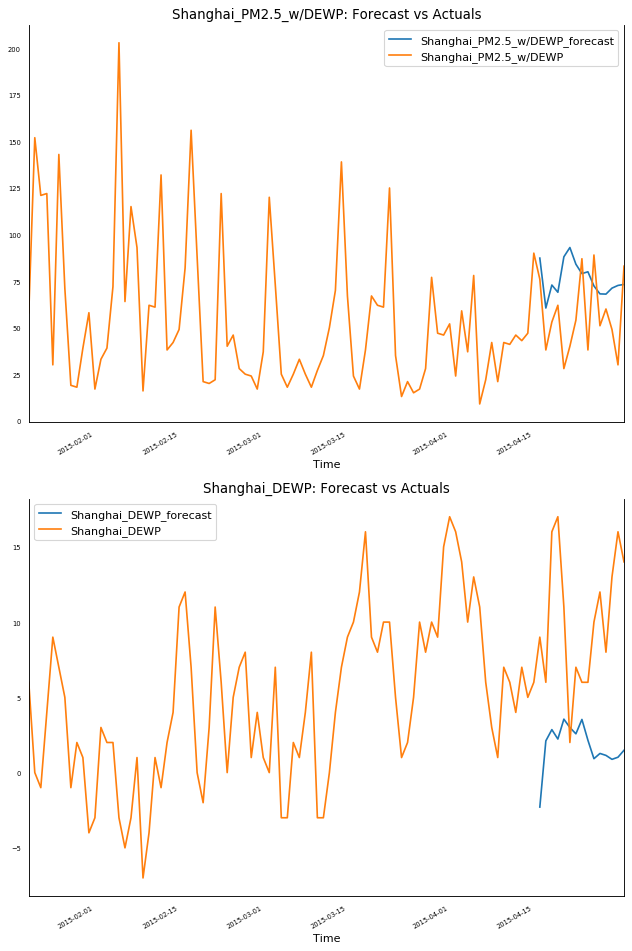

In [88]:
#results3.plot_forecast(150, plot_stderr= False);
fig, axes = plt.subplots(nrows=int(len(dataset3.columns)), ncols=1, dpi=80, figsize=(8,12))
for i, (col,ax) in enumerate(zip(dataset3.columns, axes.flatten())):
    df_results3[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dataset3[col][-100:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [89]:
test3 = dataset3[len(dataset3)-146:]

In [90]:
rmse3 = np.sqrt(mean_squared_error(test3[['Shanghai_PM2.5_w/DEWP','Shanghai_DEWP']][-15:], 
                                  df_results3[['Shanghai_PM2.5_w/DEWP_forecast','Shanghai_DEWP_forecast']][-15:]))
print("Overall RMSE: ", rmse3)

Overall RMSE:  22.111821100958313


In [91]:
rmse_PM3 = np.sqrt(mean_squared_error(test3[['Shanghai_PM2.5_w/DEWP']][-15:], 
                                  df_results3[['Shanghai_PM2.5_w/DEWP_forecast']][-15:]))
print("RMSE for Shanghai_PM2.5_forecast: ", rmse_PM3)

rmse_DEWP3 = np.sqrt(mean_squared_error(test3[['Shanghai_DEWP']][-15:], 
                                  df_results3[['Shanghai_DEWP_forecast']][-15:]))
print("RMSE for Shanghai_DEWP_forecast: ", rmse_DEWP3)


RMSE for Shanghai_PM3.5_forecast:  29.737812848343523
RMSE for Shanghai_DEWP_forecast:  9.670974707777152


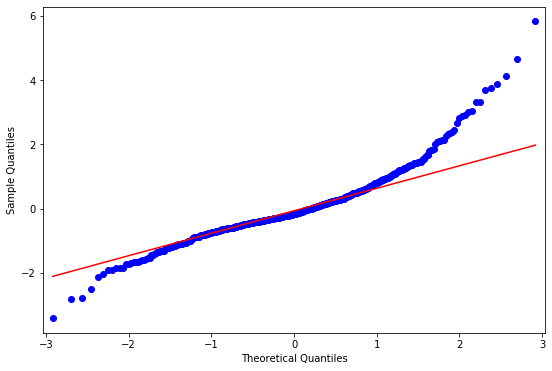

In [93]:
resid3 = results3.resid['Shanghai_PM2.5_w/DEWP']
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid3, line='q', ax=ax, fit=True)
plt.show()

In [95]:
# Split data into train / test sets 
dataset4 = Shanghai_13[['PM_US Post','Iws']]
dataset4.columns = ['Shanghai_PM2.5_w/Iws','Shanghai_Iws']
train4 = dataset4[:len(dataset)-146]
test4 = dataset4[len(dataset)-146:]
# ADF Test on each column
for i in train4.columns:
    test_stationarity(train4[i],i)
    print('\n')

train4_diff = train4.diff().dropna()
train4_diff

model4 = VAR(train4_diff)
    
#x4 = model4.select_order(maxlags=40)
#x4.summary()

results4 = model4.fit(maxlags=30, ic='aic')
print(results4.summary())

lag_order4 = results4.k_ar
#print(lag_order)

# Input data for forecasting
forecast_input4 = train4_diff.values[-lag_order4:]

#results.forecast(dataset.values[-lag_order:], 40)
fc4 = results4.forecast(y=forecast_input4, steps=15)
result_forecast4 = pd.DataFrame(fc4, index=dataset4.index[-15:], columns=dataset4.columns + '_1d')
#print(result_forecast)

df_results4 = invert_transformation(train4, result_forecast4, '_1d')  

Resluts of Dickey-Fuller Test: Shanghai_PM2.5_w/Iws
Test Statistic                 -3.019492
p-value                         0.033114
#lags used                     14.000000
Number of obervations used    569.000000
Critical Value(1%)             -3.441895
Critical Value(5%)             -2.866633
Critical Value(10%)            -2.569482
dtype: float64
 => Series is Stationary.


Resluts of Dickey-Fuller Test: Shanghai_Iws
Test Statistic               -1.841663e+01
p-value                       2.179747e-30
#lags used                    0.000000e+00
Number of obervations used    5.830000e+02
Critical Value(1%)           -3.441616e+00
Critical Value(5%)           -2.866510e+00
Critical Value(10%)          -2.569417e+00
dtype: float64
 => Series is Stationary.


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, May, 2020
Time:                     17:34:25
-------------------------------------------------------

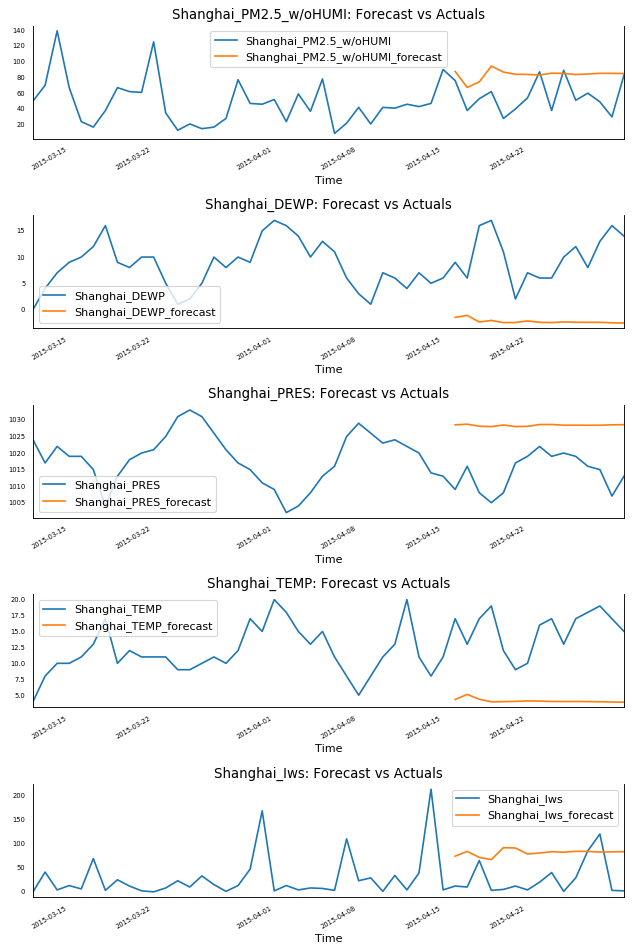

In [98]:
#results4.plot_forecast(150, plot_stderr= False);
fig, axes = plt.subplots(nrows=int(len(dataset33.columns)), ncols=1, dpi=80, figsize=(8,12))
for i, (col,ax) in enumerate(zip(dataset44.columns, axes.flatten())):
    dataset44[col][-50:].plot(legend=True, ax=ax);
    df_results44[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

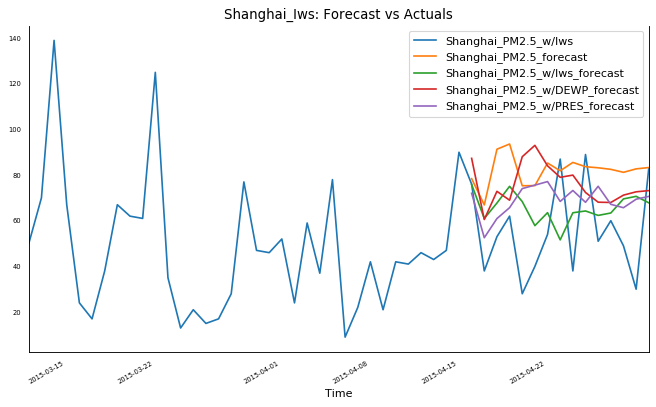

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=80, figsize=(10,6))
dataset4['Shanghai_PM2.5_w/Iws'][-50:].plot(legend=True, ax=ax);
df_results['Shanghai_PM2.5_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
df_results4['Shanghai_PM2.5_w/Iws_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
df_results3['Shanghai_PM2.5_w/DEWP_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
df_results2['Shanghai_PM2.5_w/PRES_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
ax.set_title(col + ": Forecast vs Actuals")
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines["top"].set_alpha(0)
ax.tick_params(labelsize=6)
plt.show()

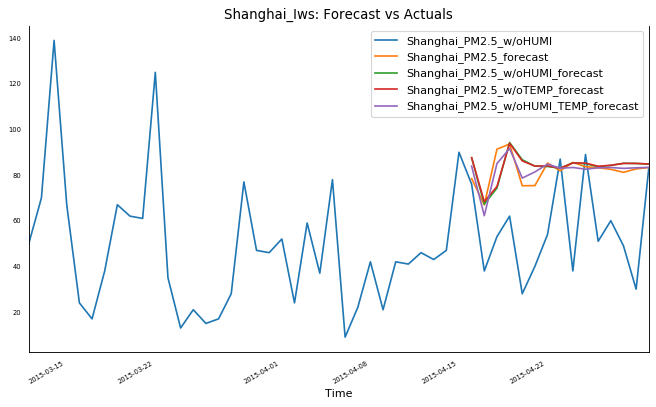

In [99]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=80, figsize=(10,6))
dataset44['Shanghai_PM2.5_w/oHUMI'][-50:].plot(legend=True, ax=ax);
df_results['Shanghai_PM2.5_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
df_results44['Shanghai_PM2.5_w/oHUMI_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
df_results33['Shanghai_PM2.5_w/oTEMP_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
df_results22['Shanghai_PM2.5_w/oHUMI_TEMP_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
ax.set_title(col + ": Forecast vs Actuals")
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines["top"].set_alpha(0)
ax.tick_params(labelsize=6)
plt.show()

In [100]:
test4 = dataset4[len(dataset4)-146:]
rmse4 = np.sqrt(mean_squared_error(test4[['Shanghai_PM2.5_w/Iws','Shanghai_Iws']][-15:], 
                                  df_results4[['Shanghai_PM2.5_w/Iws_forecast','Shanghai_Iws_forecast']][-15:]))
print("Overall RMSE: ", rmse4)

rmse_PM4 = np.sqrt(mean_squared_error(test4[['Shanghai_PM2.5_w/Iws']][-15:], 
                                  df_results4[['Shanghai_PM2.5_w/Iws_forecast']][-15:]))
print("RMSE for Shanghai_PM2.5_w/Iws_forecast: ", rmse_PM4)

rmse_Iws4 = np.sqrt(mean_squared_error(test4[['Shanghai_Iws']][-15:], 
                                  df_results4[['Shanghai_Iws_forecast']][-15:]))
print("RMSE for Shanghai_Iws_forecast: ", rmse_Iws4)

Overall RMSE:  31.54233066108149
RMSE for Shanghai_PM2.5_w/Iws_forecast:  22.97350922584244
RMSE for Shanghai_Iws_forecast:  38.23682937844265


In [101]:
#print("RMSE for Shanghai_PM2.5_forecast (ALL): ", rmse_PM)
print("RMSE for Shanghai_PM2.5_forecast (PRES) : ", rmse_PM2)
print("RMSE for Shanghai_PM2.5_forecast (DEWP) : ", rmse_PM3)
print("RMSE for Shanghai_PM2.5_forecast (Iws) : ", rmse_PM4)

RMSE for Shanghai_PM2.5_forecast (PRES) :  24.317894279006445
RMSE for Shanghai_PM2.5_forecast (DEWP) :  29.737812848343523
RMSE for Shanghai_PM2.5_forecast (Iws) :  22.97350922584244


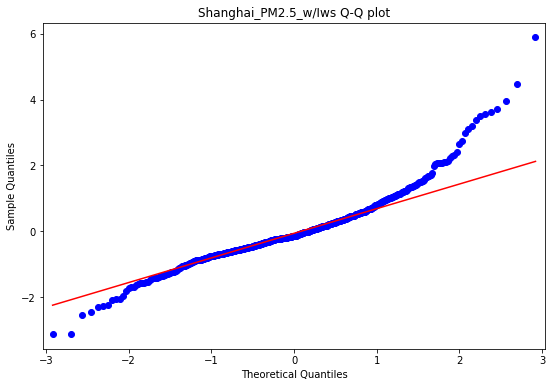

In [102]:
resid4 = results4.resid['Shanghai_PM2.5_w/Iws']
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid4, line='q', ax=ax, fit=True)
plt.title("Shanghai_PM2.5_w/Iws Q-Q plot")
plt.show()